# TASK 3 —— PRICE DEPRECIATION ANALYSIS
Given that we already have used car makes, models and price data, we are thinking about the degree of depreciation of different car makes and models. Are certain makes of cars easy to depreciate? Or the longer it is used, the easier it is to depreciate? Out of curiosity about these, we use data to verify our conjecture. Using a crawler, we obtained the new car data from sgcarmart.com. The results of our analysis may provide some references for car manufacturers, as well as some suggestions for buyers.

### Here is an overview of what we have done:
* **1. Data Preprocessing**
* **2. Data Analysis without Using Data Mining Models**
* **3. Data Analysis with Data Mining Models**

## Import Denpendencies

In [2]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_columns', None)

## Load Data & Data Overview
**Dataset Introduction:**
* Old car data, cleaned training data from task 1.
* New car data, downloaded from sgcarmart.com.

In [3]:
# load old car data
df_old = pd.read_csv('data/task1_cleaned.csv', index_col=0)
# load new car data
df_new = pd.read_csv('data/new_car.csv')

### Overview of the new car data

In [4]:
df_new.head()

,name,model,price
0,Hyundai Tucson,1.6 DCT Turbo Sunroof (A),"$171,999$15,900 /yr"
1,Hyundai Tucson,1.6 DCT Turbo S Sunroof (A),"$176,999$16,200 /yr"
2,Kia Stonic Mild Hybrid,1.0T EX (A),"$99,999$9,700 /yr"
3,Kia Stonic Mild Hybrid,1.0T SX (A),"$103,999$10,100 /yr"
4,SKODA Octavia Mild Hybrid,1.5 TSI e`TEC Ambition (A),"$63,900(w/o COE)"


In [5]:
df_new.shape

(479, 3)

### Overview of the old car data

In [6]:
df_old.head()

,title,make,model,manufactured,reg_year,transmission_auto,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,dereg_value,mileage,omv,arf,opc_revised,opc_old,road_tax,type_of_vehicle_1,type_of_vehicle_2,type_of_vehicle_3,type_of_vehicle_4,make_model_1,make_model_2,make_model_3,make_model_4,make_model_5,make_model_6,make_model_7,make_model_8,make_model_9,make_model_10,category_almost new car,category_coe car,category_consignment car,category_direct owner sale,category_electric cars,category_hybrid cars,category_imported used vehicle,category_low mileage car,category_opc car,category_parf car,category_premium ad car,category_rare & exotic,category_sgcarmart warranty cars,category_sta evaluated car,category_vintage cars,fuel_type_diesel,fuel_type_electric,fuel_type_petrol-electric,coe_valid_time,price
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,"2,013.000","2,013.000",1,"1,560.000",135.000,"1,997.000",1.000,"17,700.000","77,100.000","47,514.000","73,000.000","45,330.000","50,462.000",0,0,"1,210.000",0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,"71,300.000"
1,toyota hiace 3.0m,toyota,hiace,"2,014.000","2,015.000",0,"1,740.000",111.000,"2,982.000",3.000,"11,630.000","10,660.000","3,648.000","110,112.000","27,502.000","1,376.000",0,0,"2,363.986",0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,"43,800.000"
2,mercedes-benz cla-class cla180,mercedes-benz,cla180,"2,016.000","2,016.000",1,"1,430.000",90.000,"1,595.000",1.000,"15,070.000","53,694.000","44,517.000","80,000.000","27,886.000","26,041.000",0,0,740.000,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,"95,500.000"
3,mercedes-benz e-class e180 avantgarde,mercedes-benz,e180,"2,019.000","2,020.000",1,"1,635.000",115.000,"1,497.000",1.000,"16,400.000","40,690.000","80,301.000","9,800.000","46,412.000","56,977.000",0,0,684.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"197,900.000"
4,honda civic 1.6a vti,honda,civic,"2,019.000","2,019.000",1,"1,237.000",92.000,"1,597.000",1.000,"10,450.000","26,667.000","36,453.000","40,000.000","20,072.000","20,101.000",0,0,742.000,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"103,200.000"


In [7]:
df_old.shape

(16784, 53)

## 1. Data Preprocessing
* **1.1 Clean data**
* **1.2 Match new car data with old car data according to text similarity.**

### 1.1 Clean data

### 1.1 a) Clean data for new car

**Extract the real price of the new car**

In [8]:
def extract_price(x):
    if '$' in str(x):
        price = str(x).split('$')[1]
        price = price.split('(')[0]
        price = int(price.replace(',', ''))
    elif '¥' in str(x):
        price = str(x).split('¥')[1]
        price = int(price.replace(',', ''))
    else:
        price = int(x)
    return price

df_new = df_new[df_new.price != 'POA'].reset_index(drop=True)
df_new['new_price'] = df_new.price.apply(lambda x: extract_price(x))
df_new.head()

,name,model,price,new_price
0,Hyundai Tucson,1.6 DCT Turbo Sunroof (A),"$171,999$15,900 /yr",171999
1,Hyundai Tucson,1.6 DCT Turbo S Sunroof (A),"$176,999$16,200 /yr",176999
2,Kia Stonic Mild Hybrid,1.0T EX (A),"$99,999$9,700 /yr",99999
3,Kia Stonic Mild Hybrid,1.0T SX (A),"$103,999$10,100 /yr",103999
4,SKODA Octavia Mild Hybrid,1.5 TSI e`TEC Ambition (A),"$63,900(w/o COE)",63900


**Change name and model to lower case**

In [9]:
df_new['name'] = df_new['name'].str.lower()
df_new['model'] = df_new['model'].str.lower()
df_new.head()

,name,model,price,new_price
0,hyundai tucson,1.6 dct turbo sunroof (a),"$171,999$15,900 /yr",171999
1,hyundai tucson,1.6 dct turbo s sunroof (a),"$176,999$16,200 /yr",176999
2,kia stonic mild hybrid,1.0t ex (a),"$99,999$9,700 /yr",99999
3,kia stonic mild hybrid,1.0t sx (a),"$103,999$10,100 /yr",103999
4,skoda octavia mild hybrid,1.5 tsi e`tec ambition (a),"$63,900(w/o COE)",63900


**Remove bracket in the model of the new car**

In [10]:
def remove_bracket(x):
    return re.sub(r'\(.*\)','', x)

df_new.model = df_new.model.apply(lambda x: remove_bracket(x))
df_new.head()

,name,model,price,new_price
0,hyundai tucson,1.6 dct turbo sunroof,"$171,999$15,900 /yr",171999
1,hyundai tucson,1.6 dct turbo s sunroof,"$176,999$16,200 /yr",176999
2,kia stonic mild hybrid,1.0t ex,"$99,999$9,700 /yr",99999
3,kia stonic mild hybrid,1.0t sx,"$103,999$10,100 /yr",103999
4,skoda octavia mild hybrid,1.5 tsi e`tec ambition,"$63,900(w/o COE)",63900


**Replace \` with - in name and model**

In [11]:
df_new['name'] = df_new['name'].str.replace('`','-')
df_new['model'] = df_new['model'].str.replace('`','-')
df_new.head()

,name,model,price,new_price
0,hyundai tucson,1.6 dct turbo sunroof,"$171,999$15,900 /yr",171999
1,hyundai tucson,1.6 dct turbo s sunroof,"$176,999$16,200 /yr",176999
2,kia stonic mild hybrid,1.0t ex,"$99,999$9,700 /yr",99999
3,kia stonic mild hybrid,1.0t sx,"$103,999$10,100 /yr",103999
4,skoda octavia mild hybrid,1.5 tsi e-tec ambition,"$63,900(w/o COE)",63900


**Extract make of new car**

In [12]:
df_new['make'] = df_new['name'].apply(
    lambda x: x.split()[0] if x.split()[0] not in ['land', 'aston'] else ' '.join(x.split()[:2])
)
df_new.head()

,name,model,price,new_price,make
0,hyundai tucson,1.6 dct turbo sunroof,"$171,999$15,900 /yr",171999,hyundai
1,hyundai tucson,1.6 dct turbo s sunroof,"$176,999$16,200 /yr",176999,hyundai
2,kia stonic mild hybrid,1.0t ex,"$99,999$9,700 /yr",99999,kia
3,kia stonic mild hybrid,1.0t sx,"$103,999$10,100 /yr",103999,kia
4,skoda octavia mild hybrid,1.5 tsi e-tec ambition,"$63,900(w/o COE)",63900,skoda


**Check that all new car make can be found in old car data**

In [13]:
set(df_new['make'].unique()) - set(df_old['make'].unique()) 

set()

### 1.1 b) Clean data for used car

**Delete records of which the make does not appear in new car data**

In [14]:
makes_not_found_in_new_car = set(df_old['make'].unique()) - set(df_new['make'].unique()) 

In [15]:
df_old = df_old.drop(df_old[df_old['make'].isin(makes_not_found_in_new_car)].index)
len(df_old)

15594

**Delete `r'(coe.*)'` or `r'(opc.*)'` in the title of the old car**

In [18]:
df_old.title = df_old.title.apply(lambda x: remove_bracket(x))

**Delete records of which the price of coe is less than 10**

In [19]:
df_old = df_old[df_old.coe > 10].reset_index(drop=True)
len(df_old)

15395

### 1.2 Match new car data with old car data according to text similarity

### 1.2 a) Create a new model for old car and new car

The model information for new car can be found in both the `name` and `model`, and for old car it can be found in both `title` and `model`. As there is no clear way to extract the exact model information to match old car and new car, we used string fuzzy matching library called ‘fuzzywuzzy’ to calculate the text similarity between new car and old car. 

First, we create a new model:

* for the old car with a combination of three features: title + model, with make information removed
* for the new car with a combination of two features: name + model, with make information removed

For the new model of the old car and new car, the following steps were applied to keep both models uniformed.
* Remove duplicated words
* Sort alphabetically

For each old car, we match each new car of the same make, and calculate the text similarity of the new models created between the old car and new car. Then we analyse the similarity of matched cars and keep only matched data with high similarity.

**Get treated_model for new car**

In [20]:
df_new['treated_model'] = df_new.name + ' ' + df_new.model
df_new['treated_model'] = df_new.apply(lambda row: row['treated_model'].replace(row['make'], ''), axis=1)
df_new['treated_model'] = df_new['treated_model'].apply(lambda x: ' '.join(sorted(list(set(x.split())))))
df_new = df_new[['name', 'make', 'model', 'treated_model', 'new_price']]
df_new.columns = ['new_name', 'new_make', 'new_model', 'new_treated_model', 'new_price']
df_new

,new_name,new_make,new_model,new_treated_model,new_price
0,hyundai tucson,hyundai,1.6 dct turbo sunroof,1.6 dct sunroof tucson turbo,171999
1,hyundai tucson,hyundai,1.6 dct turbo s sunroof,1.6 dct s sunroof tucson turbo,176999
2,kia stonic mild hybrid,kia,1.0t ex,1.0t ex hybrid mild stonic,99999
3,kia stonic mild hybrid,kia,1.0t sx,1.0t hybrid mild stonic sx,103999
4,skoda octavia mild hybrid,skoda,1.5 tsi e-tec ambition,1.5 ambition e-tec hybrid mild octavia tsi,63900
...,...,...,...,...,...
451,land rover range rover sport mild hybrid,land rover,3.0 hse,3.0 hse hybrid mild range rover sport,422999
452,hino 500 diesel,hino,5.0 fd9jlna-has lwb [euro vi],5.0 500 [euro diesel fd9jlna-has lwb vi],124000
453,ferrari roma,ferrari,3.9 v8,3.9 roma v8,869000
454,volvo xc90 mild hybrid,volvo,b5 r-design,b5 hybrid mild r-design xc90,350000


**Get treated_model for old car**

In [22]:
df_old['treated_model'] = df_old.title + ' ' + df_old.model
df_old['treated_model'] = df_old.apply(lambda row: row['treated_model'].replace(row['make'], ''), axis=1)
df_old['treated_model'] = df_old['treated_model'].apply(lambda x: ' '.join(sorted(list(set(x.split())))))
df_old[['title', 'make', 'model', 'treated_model']]

,title,make,model,treated_model
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo
1,toyota hiace 3.0m,toyota,hiace,3.0m hiace
2,mercedes-benz cla-class cla180,mercedes-benz,cla180,cla-class cla180
3,mercedes-benz e-class e180 avantgarde,mercedes-benz,e180,avantgarde e-class e180
4,honda civic 1.6a vti,honda,civic,1.6a civic vti
...,...,...,...,...
15390,volvo xc90 t5 momentum,volvo,xc90,momentum t5 xc90
15391,hyundai ioniq hybrid 1.6a dct sunroof,hyundai,ioniq,1.6a dct hybrid ioniq sunroof
15392,mini cooper cabriolet 1.6a,mini,cooper,1.6a cabriolet cooper
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g


### 1.2 b) Match each old car with each new car of the same make, and calculate similarity

**Get matched new car index and similarity**

In [23]:
def get_new_car(row, df_new):
    sub_df_new = df_new[df_new['new_make'] == row['make']]
    sub_df_new_index = sub_df_new.index.to_list()
    
    new_car = []
    for i in sub_df_new_index:
        score = fuzz.ratio(row['treated_model'], df_new.iloc[i]['new_treated_model'])
        new_car.append((i, score))

    return new_car

In [24]:
df_old_match = df_old.copy(deep=True)

In [25]:
%%time
df_old_match['new_car'] = df_old_match.apply(lambda row: get_new_car(row, df_new), axis=1)

CPU times: user 2min 39s, sys: 218 ms, total: 2min 39s
Wall time: 2min 39s


In [26]:
df_old_match[['title', 'make', 'model', 'treated_model', 'new_car']]

,title,make,model,treated_model,new_car
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"[(20, 6), (50, 54), (51, 52), (52, 59), (53, 4..."
1,toyota hiace 3.0m,toyota,hiace,3.0m hiace,"[(101, 26), (102, 24), (103, 24), (104, 22), (..."
2,mercedes-benz cla-class cla180,mercedes-benz,cla180,cla-class cla180,"[(8, 45), (9, 38), (10, 40), (11, 39), (16, 64..."
3,mercedes-benz e-class e180 avantgarde,mercedes-benz,e180,avantgarde e-class e180,"[(8, 43), (9, 37), (10, 42), (11, 41), (16, 43..."
4,honda civic 1.6a vti,honda,civic,1.6a civic vti,"[(95, 24), (96, 24), (97, 18), (98, 18), (99, ..."
...,...,...,...,...,...
15390,volvo xc90 t5 momentum,volvo,xc90,momentum t5 xc90,"[(149, 32), (150, 32), (155, 22), (216, 44), (..."
15391,hyundai ioniq hybrid 1.6a dct sunroof,hyundai,ioniq,1.6a dct hybrid ioniq sunroof,"[(0, 53), (1, 54), (55, 71), (56, 89), (59, 60..."
15392,mini cooper cabriolet 1.6a,mini,cooper,1.6a cabriolet cooper,"[(303, 34), (307, 32), (308, 36), (382, 23), (..."
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"[(95, 34), (96, 29), (97, 22), (98, 22), (99, ..."


**Explode the data to get every new car index in a separate row**

In [28]:
df_old_match_explode = df_old_match.explode('new_car')
df_old_match_explode['new_index'] = df_old_match_explode['new_car'].apply(lambda x: x[0])
df_old_match_explode['similarity'] = df_old_match_explode['new_car'].apply(lambda x: x[1])
df_old_match_explode[['title', 'make', 'model', 'treated_model', 'new_car', 'new_index', 'similarity']]

,title,make,model,treated_model,new_car,new_index,similarity
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"(20, 6)",20,6
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"(50, 54)",50,54
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"(51, 52)",51,52
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"(52, 59)",52,59
0,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"(53, 44)",53,44
...,...,...,...,...,...,...,...
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"(261, 43)",261,43
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"(325, 44)",325,44
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"(347, 17)",347,17
15393,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"(386, 26)",386,26


**Create matched data using the new_index**

In [29]:
df_match = df_old_match_explode.merge(df_new, how='left', left_on='new_index', right_index=True)

In [30]:
important_cols = ['similarity', 'new_index', 'new_name', 'new_make', 'new_model', 'new_treated_model', 'new_price', 'title', 'make', 'model', 'treated_model', 'price', 'coe', 'manufactured', 'no_of_owners', 'mileage']
other_cols = sorted(list(set(df_match.columns.to_list()) - set(important_cols)))
df_match = df_match[important_cols+other_cols]
df_match

,similarity,new_index,new_name,new_make,new_model,new_treated_model,new_price,title,make,model,treated_model,price,coe,manufactured,no_of_owners,mileage,arf,category_almost new car,category_coe car,category_consignment car,category_direct owner sale,category_electric cars,category_hybrid cars,category_imported used vehicle,category_low mileage car,category_opc car,category_parf car,category_premium ad car,category_rare & exotic,category_sgcarmart warranty cars,category_sta evaluated car,category_vintage cars,coe_valid_time,curb_weight,depreciation,dereg_value,engine_cap,fuel_type_diesel,fuel_type_electric,fuel_type_petrol-electric,make_model_1,make_model_10,make_model_2,make_model_3,make_model_4,make_model_5,make_model_6,make_model_7,make_model_8,make_model_9,new_car,omv,opc_old,opc_revised,power,reg_year,road_tax,transmission_auto,type_of_vehicle_1,type_of_vehicle_2,type_of_vehicle_3,type_of_vehicle_4
0,6,20,bmw ix3 electric,bmw,impressive 74 kwh,74 electric impressive ix3 kwh,264888,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"71,300.000","77,100.000","2,013.000",1.000,"73,000.000","50,462.000",0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,560.000","17,700.000","47,514.000","1,997.000",0,0,0,0,1,0,0,0,0,0,0,0,0,"(20, 6)","45,330.000",0,0,135.000,"2,013.000","1,210.000",1,0,0,0,1
0,54,50,bmw 3 series sedan,bmw,318i sport,3 318i sedan series sport,243888,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"71,300.000","77,100.000","2,013.000",1.000,"73,000.000","50,462.000",0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,560.000","17,700.000","47,514.000","1,997.000",0,0,0,0,1,0,0,0,0,0,0,0,0,"(50, 54)","45,330.000",0,0,135.000,"2,013.000","1,210.000",1,0,0,0,1
0,52,51,bmw 3 series sedan,bmw,318i m sport,3 318i m sedan series sport,251888,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"71,300.000","77,100.000","2,013.000",1.000,"73,000.000","50,462.000",0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,560.000","17,700.000","47,514.000","1,997.000",0,0,0,0,1,0,0,0,0,0,0,0,0,"(51, 52)","45,330.000",0,0,135.000,"2,013.000","1,210.000",1,0,0,0,1
0,59,52,bmw 3 series sedan,bmw,320i m sport,3 320i m sedan series sport,295888,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"71,300.000","77,100.000","2,013.000",1.000,"73,000.000","50,462.000",0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,560.000","17,700.000","47,514.000","1,997.000",0,0,0,0,1,0,0,0,0,0,0,0,0,"(52, 59)","45,330.000",0,0,135.000,"2,013.000","1,210.000",1,0,0,0,1
0,44,53,bmw 1 series hatchback,bmw,116i sport,1 116i hatchback series sport,164888,bmw 3 series 320i gran turismo m-sport,bmw,320i,3 320i gran m-sport series turismo,"71,300.000","77,100.000","2,013.000",1.000,"73,000.000","50,462.000",0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,560.000","17,700.000","47,514.000","1,997.000",0,0,0,0,1,0,0,0,0,0,0,0,0,"(53, 44)","45,330.000",0,0,135.000,"2,013.000","1,210.000",1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15393,43,261,honda fit speedo motoring edition,honda,1.3,1.3 edition fit motoring speedo,91988,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"81,200.000","32,699.000","2,019.000",1.000,"13,000.000","5,734.000",0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,"1,030.000","7,940.000","33,506.000","1,317.000",0,0,0,0,1,0,0,1,1,1,0,0,1,"(261, 43)","15,734.000",0,0,73.000,"2,020.000",578.000,1,0,1,0,1
15393,44,325,honda grace,honda,1.5 lx,1.5 grace lx,104000,honda fit 1.3a g f-package,honda,fit,1.3a f-package fit g,"81,200.000","32,699.000","2,019.000",1.000,"13,000.000","5,734.000",0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,"1,030.000","7,940.000","33,506.000","1,317.000",0,0,0,0,1,0,0,1,1,1,0,0,1,"(325, 44)","15,734.000",0,0,73.000,"2,020.000",578.000,1,0,1,0,1
15393,17,347,honda stepwa

### 1.2 c) Analyse similarity of car matched and keep only high similarity matches

**The top similarities are 100 percent, which means that they are exactyly the same car with the same make and model.**

In [31]:
df_match['similarity'].max()

100

In [32]:
df_match[df_match['similarity'] == 100].head()

,similarity,new_index,new_name,new_make,new_model,new_treated_model,new_price,title,make,model,treated_model,price,coe,manufactured,no_of_owners,mileage,arf,category_almost new car,category_coe car,category_consignment car,category_direct owner sale,category_electric cars,category_hybrid cars,category_imported used vehicle,category_low mileage car,category_opc car,category_parf car,category_premium ad car,category_rare & exotic,category_sgcarmart warranty cars,category_sta evaluated car,category_vintage cars,coe_valid_time,curb_weight,depreciation,dereg_value,engine_cap,fuel_type_diesel,fuel_type_electric,fuel_type_petrol-electric,make_model_1,make_model_10,make_model_2,make_model_3,make_model_4,make_model_5,make_model_6,make_model_7,make_model_8,make_model_9,new_car,omv,opc_old,opc_revised,power,reg_year,road_tax,transmission_auto,type_of_vehicle_1,type_of_vehicle_2,type_of_vehicle_3,type_of_vehicle_4
6,100,88,mercedes-benz glc-class,mercedes-benz,glc63 s amg 4matic+,4matic+ amg glc-class glc63 s,541888,mercedes-benz glc-class glc63 s amg 4matic+,mercedes-benz,amg,4matic+ amg glc-class glc63 s,"367,300.000","62,100.000","2,018.000",1.000,"31,787.000","68,095.000",1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,"2,080.000","10,610.000","63,010.889","3,982.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(88, 100)","53,386.000",0,0,375.000,"2,021.000","3,922.000",1,0,1,1,0
59,100,223,mercedes-benz glc-class,mercedes-benz,glc43 amg 4matic premium plus,4matic amg glc-class glc43 plus premium,373000,mercedes-benz glc-class glc43 amg 4matic premi...,mercedes-benz,amg,4matic amg glc-class glc43 plus premium,"358,400.000","49,300.000","2,020.000",1.000,"9,000.000","109,076.000",1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"1,875.000","28,940.000","128,014.000","2,996.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(223, 100)","76,153.000",0,0,287.000,"2,021.000","2,382.000",1,0,1,1,0
193,100,22,mercedes-benz glb-class,mercedes-benz,glb200 amg line 7-seater,7-seater amg glb-class glb200 line,213000,mercedes-benz glb-class glb200 amg line 7-seater,mercedes-benz,amg,7-seater amg glb-class glb200 line,"205,700.000","47,001.000","2,020.000",1.000,11.000,"43,526.000",1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,700.000","17,220.000","77,753.000","1,332.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(22, 100)","36,804.000",0,0,120.000,"2,021.000",586.000,1,0,1,1,0
454,100,384,mercedes-benz e-class coupe,mercedes-benz,e200,coupe e-class e200,356888,mercedes-benz e-class e200 coupe,mercedes-benz,coupe,coupe e-class e200,"201,100.000","48,109.000","2,017.000",1.000,"12,790.000","84,668.000",0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,"1,655.000","22,270.000","93,843.000","1,991.000",0,0,0,0,0,0,0,1,1,1,1,1,0,"(384, 100)","62,593.000",0,0,135.000,"2,017.000","1,202.000",1,0,1,0,0
546,100,346,audi e-tron electric,audi,55 quattro,55 e-tron electric quattro,370000,audi e-tron electric 55 quattro,audi,e-tron,55 e-tron electric quattro,"319,000.000","37,000.000","2,019.000",2.000,"16,000.000","98,291.000",0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,"2,565.000","29,100.000","104,342.000","3,288.744",0,1,0,0,1,0,1,1,1,0,1,0,0,"(346, 100)","75,717.000",0,0,313.000,"2,019.000","3,683.000",1,0,1,1,0


**Similarties with 80 percent also look quite reasonable.**

In [34]:
df_match[df_match['similarity'] == 80].head(10)

,similarity,new_index,new_name,new_make,new_model,new_treated_model,new_price,title,make,model,treated_model,price,coe,manufactured,no_of_owners,mileage,arf,category_almost new car,category_coe car,category_consignment car,category_direct owner sale,category_electric cars,category_hybrid cars,category_imported used vehicle,category_low mileage car,category_opc car,category_parf car,category_premium ad car,category_rare & exotic,category_sgcarmart warranty cars,category_sta evaluated car,category_vintage cars,coe_valid_time,curb_weight,depreciation,dereg_value,engine_cap,fuel_type_diesel,fuel_type_electric,fuel_type_petrol-electric,make_model_1,make_model_10,make_model_2,make_model_3,make_model_4,make_model_5,make_model_6,make_model_7,make_model_8,make_model_9,new_car,omv,opc_old,opc_revised,power,reg_year,road_tax,transmission_auto,type_of_vehicle_1,type_of_vehicle_2,type_of_vehicle_3,type_of_vehicle_4
50,80,8,mercedes-benz glb-class,mercedes-benz,glb180 progressive 7-seater,7-seater glb-class glb180 progressive,195888,mercedes-benz glb-class glb200 progressive,mercedes-benz,glb200,glb-class glb200 progressive,"201,100.000","39,000.000","2,020.000",1.000,"9,700.000","43,611.000",1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,"1,555.000","17,260.000","69,090.000","1,332.000",0,0,0,0,1,0,0,0,1,0,1,1,1,"(8, 80)","36,865.000",0,0,120.000,"2,020.000",586.000,1,0,1,1,0
59,80,87,mercedes-benz glc-class,mercedes-benz,glc43 amg 4matic,4matic amg glc-class glc43,391888,mercedes-benz glc-class glc43 amg 4matic premi...,mercedes-benz,amg,4matic amg glc-class glc43 plus premium,"358,400.000","49,300.000","2,020.000",1.000,"9,000.000","109,076.000",1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"1,875.000","28,940.000","128,014.000","2,996.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(87, 80)","76,153.000",0,0,287.000,"2,021.000","2,382.000",1,0,1,1,0
88,80,384,mercedes-benz e-class coupe,mercedes-benz,e200,coupe e-class e200,356888,mercedes-benz e-class e200,mercedes-benz,e200,e-class e200,"51,500.000","33,018.000","1,999.000",5.000,"114,164.000","75,592.000",0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,"1,615.000","6,160.000","25,103.000","1,998.000",0,0,0,0,0,0,0,0,1,0,1,0,1,"(384, 80)","53,994.000",0,0,135.000,"1,999.000","1,815.000",1,0,0,0,1
92,80,384,mercedes-benz e-class coupe,mercedes-benz,e200,coupe e-class e200,356888,mercedes-benz e-class e200,mercedes-benz,e200,e-class e200,"108,700.000","44,996.858","2,011.000",2.000,"139,000.000","52,532.000",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10,"1,615.000","9,870.000","53,433.565","1,796.000",0,0,0,0,0,0,0,0,1,0,1,0,1,"(384, 80)","52,532.000",0,0,135.000,"2,012.000",974.000,1,0,0,0,1
193,80,21,mercedes-benz glb-class,mercedes-benz,glb200 sport 7-seater,7-seater glb-class glb200 sport,206000,mercedes-benz glb-class glb200 amg line 7-seater,mercedes-benz,amg,7-seater amg glb-class glb200 line,"205,700.000","47,001.000","2,020.000",1.000,11.000,"43,526.000",1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,700.000","17,220.000","77,753.000","1,332.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(21, 80)","36,804.000",0,0,120.000,"2,021.000",586.000,1,0,1,1,0
193,80,241,mercedes-benz glb-class carvault edition,mercedes-benz,glb200 amg line 7-seater,7-seater amg carvault edition glb-class glb200...,122999,mercedes-benz glb-class glb200 amg line 7-seater,mercedes-benz,amg,7-seater amg glb-class glb200 line,"205,700.000","47,001.000","2,020.000",1.000,11.000,"43,526.000",1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,700.000","17,220.000","77,753.000","1,332.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(241, 80)","36,804.000",0,0,120.000,"2,021.000",586.000,1,0,1,1,0
203,80,226,porsche 911,porsche,carrera pdk 3.0,3.0 911 carrera pdk,506000,porsche 911 carrera coupe 3.6a pdk,porsche,911,3.6a 911 carrera coupe pdk,"317,700.000","44,202.644","2,010.000",3.000,"68,027.000","108,132.000",0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,10,"1,505.000","28,860.000","87,649.282","3,614.000",0,0,0,0,0,0,0,1,1,1,0,1,1,"(226, 80)","108,132.000",0,0,254.000,"2,011.000","3,346.000",1,0,1,0,0
262,80,97,honda freed hybrid,honda,1.5 g honda sensi

**Keep only data with similarity no less than 80**

In [39]:
df_match_pruned = df_match[df_match['similarity'] >= 80].sort_values('similarity', ascending=False).reset_index(drop=True)
df_match_pruned

,similarity,new_index,new_name,new_make,new_model,new_treated_model,new_price,title,make,model,treated_model,price,coe,manufactured,no_of_owners,mileage,arf,category_almost new car,category_coe car,category_consignment car,category_direct owner sale,category_electric cars,category_hybrid cars,category_imported used vehicle,category_low mileage car,category_opc car,category_parf car,category_premium ad car,category_rare & exotic,category_sgcarmart warranty cars,category_sta evaluated car,category_vintage cars,coe_valid_time,curb_weight,depreciation,dereg_value,engine_cap,fuel_type_diesel,fuel_type_electric,fuel_type_petrol-electric,make_model_1,make_model_10,make_model_2,make_model_3,make_model_4,make_model_5,make_model_6,make_model_7,make_model_8,make_model_9,new_car,omv,opc_old,opc_revised,power,reg_year,road_tax,transmission_auto,type_of_vehicle_1,type_of_vehicle_2,type_of_vehicle_3,type_of_vehicle_4
0,100,58,kia stonic,kia,1.0t ex,1.0t ex stonic,96999,kia stonic 1.0t ex,kia,stonic,1.0t ex stonic,"89,000.000","35,710.000","2,019.000",1.000,"14,629.000","7,844.000",1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,"1,185.000","8,540.000","38,051.000",998.000,0,0,0,0,1,0,1,1,1,0,0,0,1,"(58, 100)","17,844.000",0,0,88.300,"2,020.000",392.000,1,0,1,1,0
1,100,85,mercedes-benz glc-class,mercedes-benz,glc200,glc-class glc200,286888,mercedes-benz glc-class glc200,mercedes-benz,glc200,glc-class glc200,"158,200.000","49,996.000","2,017.000",2.000,"68,000.000","51,101.000",0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,"1,705.000","18,880.000","69,638.000","1,991.000",0,0,0,0,1,1,0,0,1,0,0,1,0,"(85, 100)","42,215.000",0,0,135.000,"2,017.000","1,202.000",1,0,1,1,0
2,100,72,mercedes-benz gla-class,mercedes-benz,gla200 sport executive,executive gla-class gla200 sport,199000,mercedes-benz gla-class gla200 sport executive,mercedes-benz,gla200,executive gla-class gla200 sport,"196,900.000","60,109.000","2,020.000",1.000,652.000,"39,970.000",1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,"1,435.000","16,210.000","88,934.000","1,332.000",0,0,0,0,1,0,1,1,0,0,0,0,0,"(72, 100)","34,264.000",0,0,120.000,"2,021.000",586.000,1,0,1,1,0
3,100,85,mercedes-benz glc-class,mercedes-benz,glc200,glc-class glc200,286888,mercedes-benz glc-class glc200,mercedes-benz,glc200,glc-class glc200,"174,700.000","32,001.000","2,018.000",1.000,"35,000.000","51,597.000",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,"1,705.000","18,600.000","61,581.000","1,991.000",0,0,0,0,1,1,0,0,1,0,0,1,0,"(85, 100)","42,569.000",0,0,135.000,"2,018.000","1,202.000",1,0,1,1,0
4,100,223,mercedes-benz glc-class,mercedes-benz,glc43 amg 4matic premium plus,4matic amg glc-class glc43 plus premium,373000,mercedes-benz glc-class glc43 amg 4matic premi...,mercedes-benz,amg,4matic amg glc-class glc43 plus premium,"339,700.000","49,300.000","2,020.000",1.000,"10,500.000","109,076.000",1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"1,875.000","27,230.000","127,838.000","2,996.000",0,0,0,0,0,0,0,0,0,0,1,0,0,"(223, 100)","76,153.000",0,0,287.000,"2,021.000","2,382.000",1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,80,405,mini john cooper works clubman,mini,2.0,2.0 clubman cooper john works,261888,mini cooper s clubman 2.0a,mini,cooper,2.0a clubman cooper s,"165,000.000","37,000.000","2,019.000",2.000,"2,200.000","46,532.000",0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,"1,390.000","15,660.000","64,834.000","1,998.000",0,0,0,0,1,0,0,0,0,1,1,0,1,"(405, 80)","38,951.000",0,0,141.000,"2,019.000","1,210.000",1,0,1,0,0
3932,80,106,mercedes-benz a-class saloon,mercedes-benz,a200 progressive,a-class a200 progressive saloon,219888,mercedes-benz a-class a180 progressive,mercedes-benz,a180,a-class a180 progressive,"158,200.000","35,990.000","2,020.000",1.000,"3,450.000","35,682.000",1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,"1,365.000","13,330.000","60,760.000","1,332.000",0,0,0,0,0,0,1,1,0,0

## 2. Data Analysis without Using Data Mining Models
* **2.1 Data preparation for analysis**
* **2.2 Price comparison between new car and old car**
* **2.3 Price depreciation with different makes**
* **2.4 Price depreciation with different used years**
* **2.5 Price depreciation with different number of owners**

### 2.1 Data preparation for analysis
Here we want know the relationship between price depreciation and car makes, average used years and history number of owners. Therefore, we process the old car data to obtain these features: 
* used_years, from the feature manufactured
* no_owners, directly from the data
* price_loss, calculated by the formula `price_loss = (new_price - (old_price - old_coe)) / new_price`
* price_loss_per_year, calculated by the formula `price_loss_per_year = price_loss / used_years`

In [40]:
df_match_pruned['used_years'] = 2022 - df_match_pruned['manufactured']
df_match_pruned['price_loss'] = (df_match_pruned['new_price'] - df_match_pruned['price'] + df_match_pruned['coe'])/df_match_pruned['new_price']
df_match_pruned['price_loss_per_year'] = df_match_pruned['price_loss']/df_match_pruned['used_years']

### 2.2 Price comparison between new car and old car

In [133]:
df_mean = df_match_pruned.groupby(['new_index']).mean()

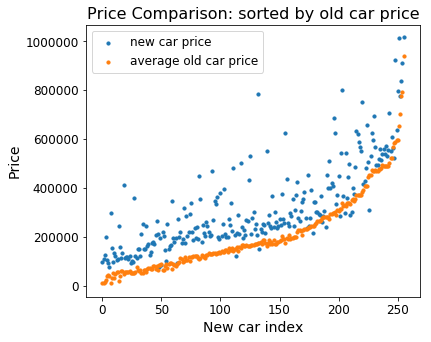

In [194]:
df_mean = df_mean.sort_values('price')
x = np.arange(len(df_mean))

y1 = df_mean['new_price']
y2 = df_mean['price'] - df_mean['coe']

plt.scatter(x, y1,label='new car price',s=10)
plt.scatter(x, y2,label='average old car price',s=10)
plt.title('Price Comparison: sorted by old car price', size=16)
plt.xlabel('New car index', size=14)
plt.ylabel('Price', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_comparison_sort_by_old_car_price.png', bbox_inches='tight')

### 2.3 Price depreciation with different makes

In [172]:
df_make = df_match_pruned.groupby(['make']).mean().reset_index()
df_make = df_make.sort_values('price_loss_per_year')
df_make = df_make[['make', 'price', 'coe', 'new_price', 'used_years', 'price_loss_per_year']]
df_make = df_make.merge(df_match_pruned.groupby(['make']).size().to_frame('count'), left_on='make', right_index=True)
df_make

,make,price,coe,new_price,used_years,price_loss_per_year,count
16,skoda,"125,607.692","38,031.077","87,900.000",3.077,-0.001,13
2,bentley,"816,900.000","40,466.500","839,000.000",3.167,0.016,6
14,porsche,"345,962.500","51,846.762","483,852.479",7.181,0.041,376
0,aston martin,"638,000.000","39,903.000","799,000.000",4.000,0.063,1
8,maserati,"215,520.635","51,641.752","507,146.032",9.968,0.067,63
10,mercedes-benz,"233,125.129","46,371.696","293,593.168",3.736,0.091,2137
7,land rover,"226,057.143","44,321.607","374,534.714",4.643,0.105,28
3,bmw,"144,615.556","52,659.039","286,230.844",6.422,0.120,180
12,mini,"149,738.636","45,735.599","236,585.091",5.477,0.124,44
1,audi,"155,507.246","50,539.028","284,029.203",7.058,0.124,69


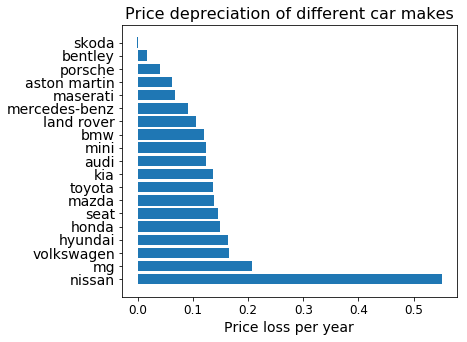

In [201]:
fig, ax = plt.subplots(figsize=(6,5))

cars = df_make['make']
y_pos = np.arange(len(cars))

price_loss = df_make['price_loss_per_year']

ax.barh(y_pos, price_loss, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cars, size=14)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Price loss per year', size=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('Price depreciation of different car makes', size=16)
plt.savefig('images/price_depreciation_of_different_car_makes.png', bbox_inches='tight')

### 2.4 Price depreciation with different used years
We noticed in 2.3 that 5 car makes have matched data amount larger than 100, which are Porsche, Mercedes-Benz, BMW, Toyota, and Honda.

Out of the 5 makes, Porsche has the lowest average price_loss_per_year, and Honda has the highest. Therefore, we take Porsche and Honda as two examples to analysis the relationship between price depreciation with used years.

**Price depreciation with different used years (Porsche)**

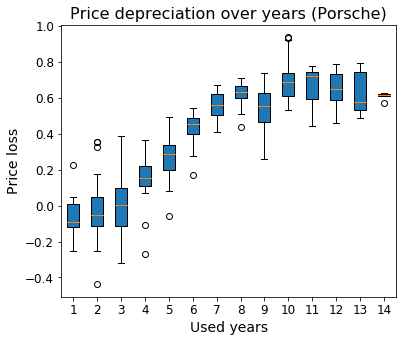

In [225]:
%%capture --no-display
porsche = df_match_pruned[df_match_pruned['make']=='porsche']
all_data = dict()
labels = list()
for keys, values in porsche.groupby('used_years'):
    all_data[keys] = values['price_loss'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Used years', size=14)
plt.ylabel('Price loss', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Price depreciation over years (Porsche)', size=16)
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_depredication_over_years_porsche.png', bbox_inches='tight')

**Price depreciation with different used years (Honda)**

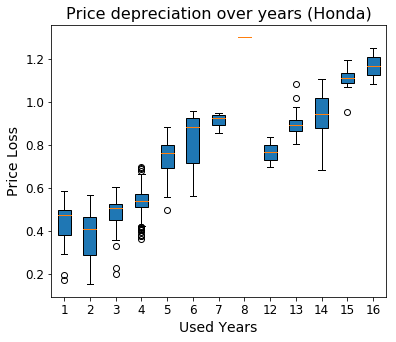

In [217]:
%%capture --no-display
honda = df_match_pruned[df_match_pruned['make']=='honda']
all_data = dict()
labels = list()
for keys, values in honda.groupby('used_years'):
    all_data[keys] = values['price_loss'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Used Years', size=14)
plt.ylabel('Price Loss', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Price depreciation over years (Honda)', size=16)
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_depredication_over_years_honda.png', bbox_inches='tight')

### 2.5 Price depreciation with different number of owners
Intuition tells us that the more times an old car changes hands, the more discount. We take porsche and honda as two examples to verify our guess.

**Price depreciation with different number of owners (Porsche)**

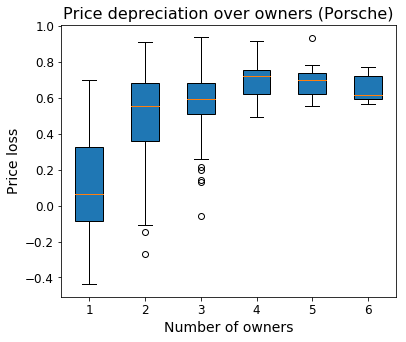

In [218]:
%%capture --no-display
all_data = dict()
labels = list()
for keys, values in porsche.groupby('no_of_owners'):
    all_data[keys] = values['price_loss'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Number of owners', size=14)
plt.ylabel('Price loss', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Price depreciation over owners (Porsche)', size=16)
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_depredication_over_owners_porsche.png', bbox_inches='tight')

**Price depreciation with different number of owners (Honda)**

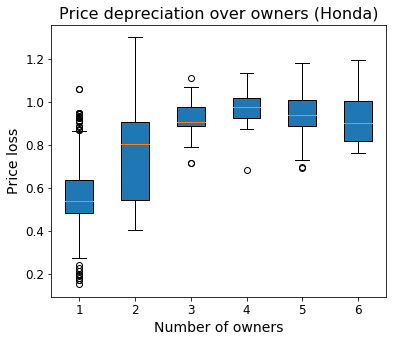

In [222]:
%%capture --no-display
all_data = dict()
labels = list()
for keys, values in honda.groupby('no_of_owners'):
    all_data[keys] = values['price_loss'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Number of owners', size=14)
plt.ylabel('Price loss', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Price depreciation over owners (Honda)', size=16)
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_depredication_over_owners_honda.png', bbox_inches='tight')

# 3. Data Analysis with Data Mining Models

* **3.1 Data preparation**
* **3.2 Linear regression of price loss against a single feature**
* **3.3 Linear regression of price loss against all 4 features**
* **3.4 Linear regression with more control variables**
* **3.5 Add car make to linear regression analysis**

## 3.1 Data preparation
We intend to use linear regression with OLS estimation to find the relationship between price depreciation and some car features, as well as makes of the car.

We think some important factors that might affect price depreciation are:
* new car price
    * a variable `new_price/100k` is created to represent the price in unit of 100k
* old car used years
    * a variable `used_years_2` is created to be the square of used years, as the relationship may not be linear from the graphs in 2.4
* old car number of owners
    * a variable `no_of_owners_2` is created to be the square of number of owners, as the relationship may not be linear from the graphs in 2.5
* old car mileage 
    * a variable `mileage/1k` is created to represent the mileage in unit of 1k km
    * a variable `mileage/1k_2` is created to be the square of mileage, as the relationship may not be linear
* car make
    * for the 5 car makes with data amount more than 100, we create 5 binary variables to represent whether the data is one of the 5 makes

In [226]:
df_ols = df_match_pruned.copy(deep=True)
df_ols['new_price/100k'] = df_ols['new_price'] / 100000
df_ols['used_years_2'] = df_ols['used_years'] ** 2
df_ols['no_of_owners_2'] = df_ols['no_of_owners'] ** 2
df_ols['mileage/1k'] = df_ols['mileage'] / 1000
df_ols['mileage/1k_2'] = df_ols['mileage/1k'] ** 2

df_ols['porsche'] = df_ols['make'].apply(lambda x: 1 if x == 'porsche' else 0)
df_ols['mercedes-benz'] = df_ols['make'].apply(lambda x: 1 if x == 'mercedes-benz' else 0)
df_ols['bmw'] = df_ols['make'].apply(lambda x: 1 if x == 'bmw' else 0)
df_ols['toyota'] = df_ols['make'].apply(lambda x: 1 if x == 'toyota' else 0)
df_ols['honda'] = df_ols['make'].apply(lambda x: 1 if x == 'honda' else 0)

## 3.2 Linear regression of price loss against a single feature

**Fit simple OLS model for new_price, used_years, number_of_owners, mileage separately**

In [227]:
y = df_ols[['price_loss']]
X_price = sm.add_constant(df_ols[['new_price/100k']])
X_used_years = sm.add_constant(df_ols[['used_years', 'used_years_2']])
X_no_of_owners = sm.add_constant(df_ols[['no_of_owners', 'no_of_owners_2']])
X_mileage = sm.add_constant(df_ols[['mileage/1k', 'mileage/1k_2']])

In [228]:
ols_price = sm.OLS(y, X_price).fit()
ols_used_years = sm.OLS(y, X_used_years).fit()
ols_no_of_owners = sm.OLS(y, X_no_of_owners).fit()
ols_mileage = sm.OLS(y, X_mileage).fit()

## 3.2 a) Estimated coefficient and statistical significan level

**price_loss against new_price**

In [229]:
result_ols_price = pd.DataFrame({'coefficient': ols_price.params, 'p': ols_price.pvalues})
result_ols_price['significance'] = result_ols_price['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_price['variable'] = ['const', 'new_price/100k']
result_ols_price.set_index('variable')

,coefficient,p,significance
variable,,,
const,0.533,0.000,< 0.01
new_price/100k,-0.030,0.000,< 0.01


**price_loss against used_years**

In [231]:
result_ols_used_years = pd.DataFrame({'coefficient': ols_used_years.params, 'p': ols_used_years.pvalues})
result_ols_used_years['significance'] = result_ols_used_years['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_used_years['variable'] = ['const', 'used_years', 'used_years_square']
result_ols_used_years.set_index('variable')

,coefficient,p,significance
variable,,,
const,-0.013,0.190,
used_years,0.128,0.000,< 0.01
used_years_square,-0.004,0.000,< 0.01


**price_loss against number of owners**

In [232]:
result_ols_no_of_owners = pd.DataFrame({'coefficient': ols_no_of_owners.params, 'p': ols_no_of_owners.pvalues})
result_ols_no_of_owners['significance'] = result_ols_no_of_owners['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_no_of_owners['variable'] = ['const', 'no_of_owners', 'no_of_owners_square']
result_ols_no_of_owners.set_index('variable')

,coefficient,p,significance
variable,,,
const,0.024,0.159,
no_of_owners,0.376,0.000,< 0.01
no_of_owners_square,-0.043,0.000,< 0.01


**price_loss against number of mileage**

In [233]:
result_ols_mileage = pd.DataFrame({'coefficient': ols_mileage.params, 'p': ols_mileage.pvalues})
result_ols_mileage['significance'] = result_ols_mileage['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_mileage['variable'] = ['const', 'mileage/1k', 'mileage/1k_square']
result_ols_mileage.set_index('variable')

,coefficient,p,significance
variable,,,
const,0.181,0.000,< 0.01
mileage/1k,0.010,0.000,< 0.01
mileage/1k_square,-0.000,0.000,< 0.01


## 3.2 b) Plot actual data and fitted data

In [235]:
y_price = ols_price.params[0] + df_ols['new_price/100k'] * ols_price.params[1]
y_used_years = ols_used_years.params[0] + df_ols['used_years'] * ols_used_years.params[1] + df_ols['used_years_2'] * ols_used_years.params[2]
y_no_of_owners = ols_no_of_owners.params[0] + df_ols['no_of_owners'] * ols_no_of_owners.params[1] + df_ols['no_of_owners_2'] * ols_no_of_owners.params[2]
y_mileage = ols_mileage.params[0] + df_ols['mileage/1k'] * ols_mileage.params[1] + df_ols['mileage/1k_2'] * ols_mileage.params[2]

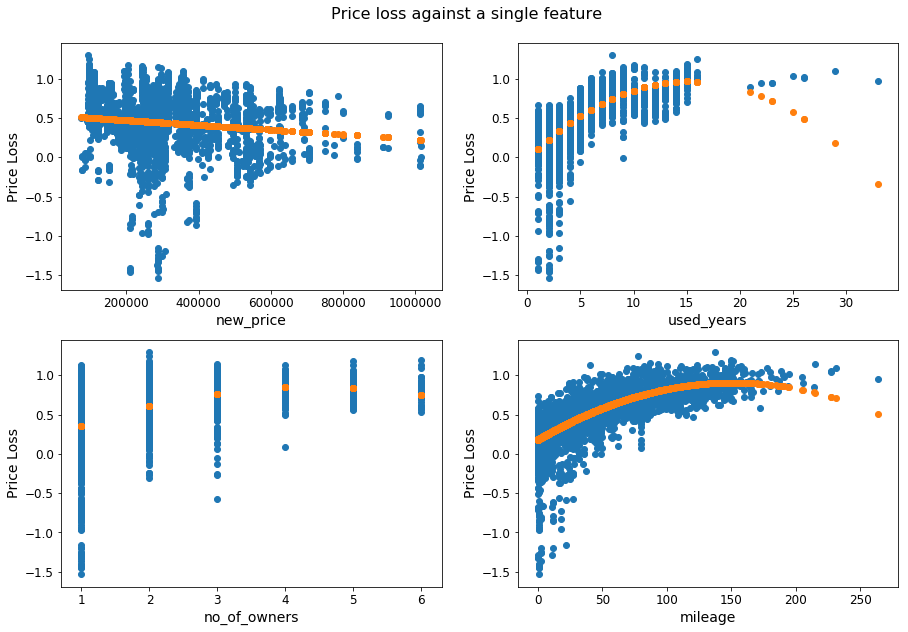

In [260]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in [0, 1]:
    for j in [0, 1]:
        ax[i][j].set_ylabel('Price Loss', size=14)
        ax[i][j].xaxis.set_tick_params(labelsize=12)
        ax[i][j].yaxis.set_tick_params(labelsize=12)

ax[0][0].set_xlabel('new_price', size=14)
ax[0][0].scatter(df_ols['new_price'], y)
ax[0][0].scatter(df_ols['new_price'], y_price)

ax[0][1].set_xlabel('used_years', size=14)
ax[0][1].scatter(df_ols['used_years'], y)
ax[0][1].scatter(df_ols['used_years'], y_used_years)

ax[1][0].set_xlabel('no_of_owners', size=14)
ax[1][0].scatter(df_ols['no_of_owners'], y)
ax[1][0].scatter(df_ols['no_of_owners'], y_no_of_owners)

ax[1][1].set_xlabel('mileage', size=14)
ax[1][1].scatter(df_ols['mileage/1k'], y)
ax[1][1].scatter(df_ols['mileage/1k'], y_mileage)

plt.suptitle('Price loss against a single feature', size=16, y=0.93)
plt.rcParams["figure.figsize"] = (6,5)
plt.savefig('images/price_loss_against_a_single_feature.png', bbox_inches='tight')

## 3.3 Linear regression of price loss against all 4 features

In [261]:
main_vars = [
    'new_price/100k', 
    'used_years', 'used_years_2', 
    'no_of_owners', 'no_of_owners_2', 
    'mileage/1k', 'mileage/1k_2'
]

In [262]:
X_4_variables = sm.add_constant(df_ols[main_vars])
ols_4_variables = sm.OLS(y, X_4_variables).fit()
print(ols_4_variables.summary())

                            OLS Regression Results                            
Dep. Variable:             price_loss   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     772.4
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:33:41   Log-Likelihood:                 496.25
No. Observations:                3936   AIC:                            -976.5
Df Residuals:                    3928   BIC:                            -926.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1659      0.015     10.

## 3.4 Linear regression with more control variables

In [263]:
control_vars = [
    'omv', 'arf', 'depreciation', 'dereg_value',
    'power', 'engine_cap', 'road_tax', 
    'transmission_auto', 'curb_weight'
] + [col for col in df_ols if col.startswith('type_of_vehicle_') or col.startswith('fuel_type_') ]

In [264]:
X_control = sm.add_constant(df_ols[main_vars + control_vars])
ols_control = sm.OLS(y, X_control).fit()

result_ols_control = pd.DataFrame({'coefficient': ols_control.params[:8], 'p': ols_control.pvalues[:8]})
result_ols_control['significance'] = result_ols_control['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_control['variable'] = ['const'] + main_vars
result_ols_control.set_index('variable')

,coefficient,p,significance
variable,,,
const,0.201,0.000,< 0.01
new_price/100k,0.160,0.000,< 0.01
used_years,0.081,0.000,< 0.01
used_years_2,-0.002,0.000,< 0.01
no_of_owners,0.039,0.000,< 0.01
no_of_owners_2,-0.007,0.000,< 0.01
mileage/1k,0.004,0.000,< 0.01
mileage/1k_2,-0.000,0.000,< 0.01


## 3.5 Add car make to linear regression

In [265]:
makes = ['porsche', 'mercedes-benz', 'bmw', 'toyota', 'honda']

In [266]:
X_control_make = sm.add_constant(df_ols[makes + main_vars + control_vars])
ols_control_make = sm.OLS(y, X_control_make).fit()

result_ols_control_make = pd.DataFrame({'coefficient': ols_control_make.params[:13], 'p': ols_control_make.pvalues[:13]})
result_ols_control_make['significance'] = result_ols_control_make['p'].apply(lambda x: '< 0.01' if x < 0.01 else '')
result_ols_control_make['variable'] = ['const'] + makes + main_vars
result_ols_control_make.set_index('variable')

,coefficient,p,significance
variable,,,
const,0.136,0.001,< 0.01
porsche,-0.104,0.000,< 0.01
mercedes-benz,-0.093,0.000,< 0.01
bmw,-0.010,0.429,
toyota,0.002,0.882,
honda,0.007,0.570,
new_price/100k,0.166,0.000,< 0.01
used_years,0.073,0.000,< 0.01
used_years_2,-0.002,0.000,< 0.01
